## 0. Getting Setup

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.0.1+cu118
torchvision version: 0.15.2+cu118


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3905, done.
remote: Counting objects: 100% (1096/1096), done.
remote: Compressing objects: 100% (158/158), done.
remote: Total 3905 (delta 986), reused 984 (delta 935), pack-reused 2809
Receiving objects: 100% (3905/3905), 649.59 MiB | 28.68 MiB/s, done.
Resolving deltas: 100% (2277/2277), done.
Updating files: 100% (248/248), done.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Getting Data

In [4]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [5]:
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

## 2. What are we going to build?
* EffnetB2 on 20% food data
* ViT on 20% food data

## 3. Creating an EffnetB2 feature extractor

In [6]:
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

effnetb2_transforms = effnetb2_weights.transforms()

effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

for param in effnetb2.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 195MB/s]


In [7]:
from torchinfo import summary

# # Print EffNetB2 model summary (uncomment for full output)
summary(effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   False
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16,

In [8]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [9]:
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=3, bias=True)
)

In [10]:
from torchinfo import summary

# # Print EffNetB2 model summary (uncomment for full output)
summary(effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### 3.1 Creating a function to make an EffNetB2 feature extractor

In [11]:
def create_effnet_b2(num_classes: int = 3):
    effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

    effnetb2_transforms = effnetb2_weights.transforms()

    effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

    for param in effnetb2.parameters():
        param.requires_grad = False

    effnetb2.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes, bias=True)
    )
    return effnetb2, effnetb2_transforms


In [12]:
effnetb2, effnetb2_transforms = create_effnet_b2(num_classes=3)

In [13]:
from torchinfo import summary

# # Print EffNetB2 model summary (uncomment for full output)
summary(effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### 3.2 Creating dataloaders for EffnetB2

In [14]:
# Setup DataLoaders
from going_modular.going_modular import data_setup
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)

### 3.3 Training EffNetB2 model

In [15]:
from going_modular.going_modular import engine

loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=1e-3)

effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                epochs=10,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9308 | train_acc: 0.6521 | test_loss: 0.7206 | test_acc: 0.9381
Epoch: 2 | train_loss: 0.6981 | train_acc: 0.8187 | test_loss: 0.5706 | test_acc: 0.9534
Epoch: 3 | train_loss: 0.5561 | train_acc: 0.8625 | test_loss: 0.4690 | test_acc: 0.9597
Epoch: 4 | train_loss: 0.4736 | train_acc: 0.8917 | test_loss: 0.4351 | test_acc: 0.9534
Epoch: 5 | train_loss: 0.4616 | train_acc: 0.8812 | test_loss: 0.3878 | test_acc: 0.9472
Epoch: 6 | train_loss: 0.4136 | train_acc: 0.8854 | test_loss: 0.3433 | test_acc: 0.9750
Epoch: 7 | train_loss: 0.4408 | train_acc: 0.8750 | test_loss: 0.3413 | test_acc: 0.9597
Epoch: 8 | train_loss: 0.3330 | train_acc: 0.9187 | test_loss: 0.2953 | test_acc: 0.9625
Epoch: 9 | train_loss: 0.2996 | train_acc: 0.9375 | test_loss: 0.2872 | test_acc: 0.9812
Epoch: 10 | train_loss: 0.3527 | train_acc: 0.8750 | test_loss: 0.2968 | test_acc: 0.9597


## 3.4 Inspecting the loss curves for effnetb2

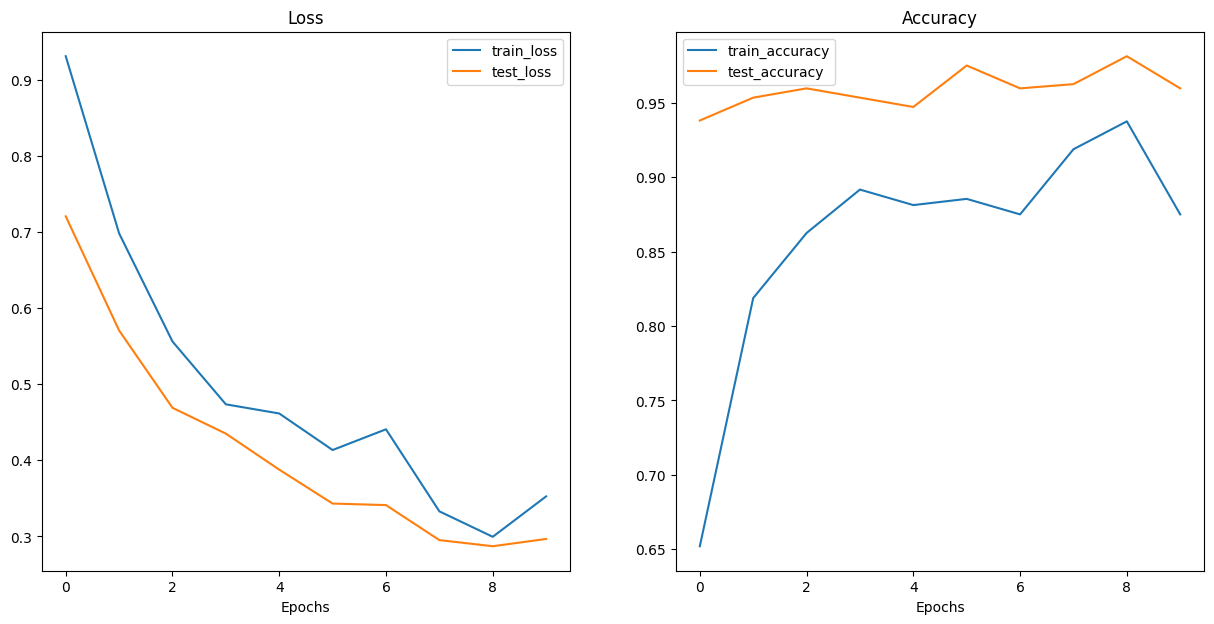

In [16]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

### 3.5 Saving EffNetB2 feature extractor

In [17]:
from going_modular.going_modular import utils
utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="09_Pytorch_Model_Deployment_effnetb2.pth")

[INFO] Saving model to: models/09_Pytorch_Model_Deployment_effnetb2.pth


### 3.6 Inspecting the size of EffNetB2 feature extractor

In [18]:
from pathlib import Path

pretrained_effnetb2_model_size = Path("models/09_Pytorch_Model_Deployment_effnetb2.pth").stat().st_size // (1024 * 1024)

In [19]:
pretrained_effnetb2_model_size

29

### 3.7 Collecting EFfNetB2 feature extractor stats

In [20]:
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [21]:
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size_MB": pretrained_effnetb2_model_size}

In [22]:
effnetb2_stats

{'test_loss': 0.2967515617609024,
 'test_acc': 0.959659090909091,
 'number_of_parameters': 7705221,
 'model_size_MB': 29}

## 4. Creating a ViT feature extractor

In [23]:
def create_vit_model(num_classes: int=3):
  vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

  vit_transforms = vit_weights.transforms()

  vit_model = torchvision.models.vit_b_16(weights=vit_weights)

  for param in vit_model.parameters():
    param.requires_grad = False

  vit_model.heads = nn.Sequential(
      nn.Linear(in_features=768,
                out_features=num_classes)
  )
  return vit_model, vit_transforms


In [24]:
vit_model, vit_transforms = create_vit_model()

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 236MB/s]


In [25]:
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [26]:
from torchinfo import summary

# # Print vit model summary (uncomment for full output)
summary(vit_model,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### 4.1 Create DataLoaders for ViT feature extractor

In [27]:
# Setup ViT DataLoaders
from going_modular.going_modular import data_setup
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       batch_size=32)

### 4.2 Training ViT Feature Extractor

In [28]:
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params=vit_model.parameters(),
                             lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss()

vit_results = engine.train(model=vit_model,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           epochs=10,
                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5678 | train_acc: 0.8292 | test_loss: 0.2054 | test_acc: 0.9625
Epoch: 2 | train_loss: 0.2085 | train_acc: 0.9417 | test_loss: 0.1086 | test_acc: 0.9875
Epoch: 3 | train_loss: 0.1452 | train_acc: 0.9563 | test_loss: 0.0824 | test_acc: 0.9938
Epoch: 4 | train_loss: 0.1252 | train_acc: 0.9625 | test_loss: 0.0694 | test_acc: 0.9875
Epoch: 5 | train_loss: 0.0974 | train_acc: 0.9708 | test_loss: 0.0618 | test_acc: 0.9938
Epoch: 6 | train_loss: 0.0821 | train_acc: 0.9771 | test_loss: 0.0583 | test_acc: 0.9938
Epoch: 7 | train_loss: 0.0721 | train_acc: 0.9812 | test_loss: 0.0559 | test_acc: 0.9938
Epoch: 8 | train_loss: 0.0616 | train_acc: 0.9833 | test_loss: 0.0535 | test_acc: 0.9938
Epoch: 9 | train_loss: 0.0559 | train_acc: 0.9917 | test_loss: 0.0515 | test_acc: 0.9938
Epoch: 10 | train_loss: 0.0480 | train_acc: 0.9938 | test_loss: 0.0497 | test_acc: 0.9938


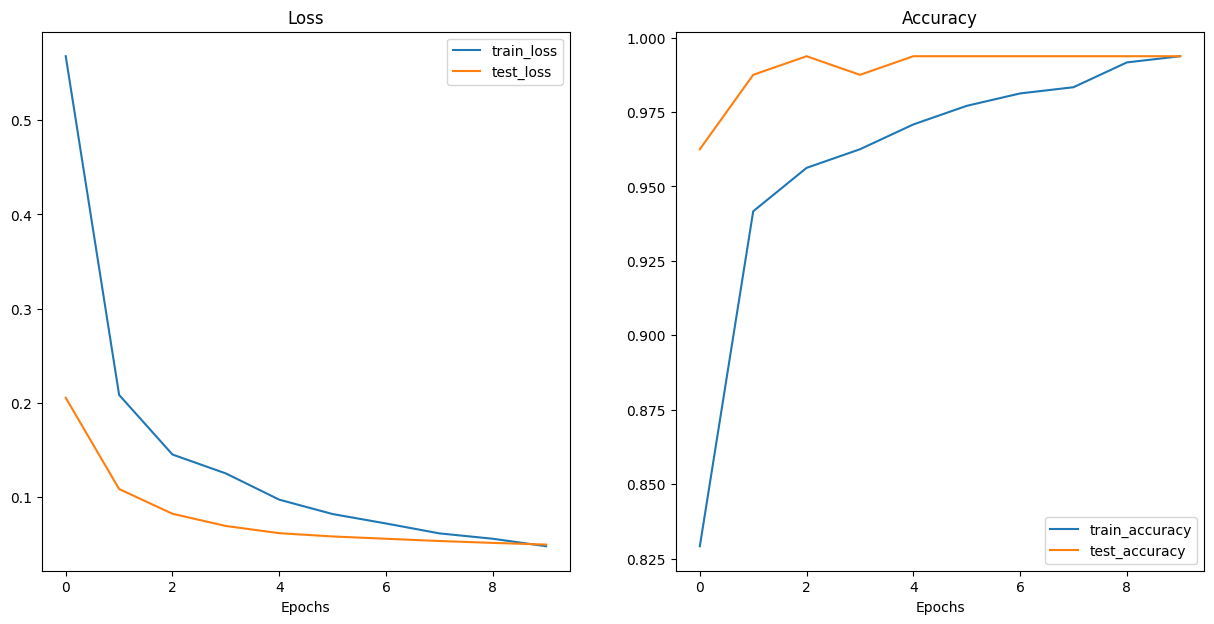

In [29]:
from helper_functions import plot_loss_curves
plot_loss_curves(vit_results)

### 4.4 Saving ViT

In [30]:
from going_modular.going_modular import utils

utils.save_model(model=vit_model,
                 target_dir="models",
                 model_name="09_pretrained_vit_feature_extractor.pth")

[INFO] Saving model to: models/09_pretrained_vit_feature_extractor.pth


In [31]:
pretrained_vit_model_size = Path("models/09_pretrained_vit_feature_extractor.pth").stat().st_size // (1024 * 1024)

In [32]:
pretrained_vit_model_size

327

### 4.6 Collecting ViT feature extractor stats

In [33]:
vit_total__params = sum(torch.numel(param) for param in vit_model.parameters())
vit_total__params

85800963

In [34]:
vit_stats = {"test_loss": vit_results["test_loss"][-1],
                  "test_acc": vit_results["test_acc"][-1],
                  "number_of_parameters": vit_total__params,
                  "model_size_MB": pretrained_vit_model_size}

In [35]:
vit_stats

{'test_loss': 0.049699126416817306,
 'test_acc': 0.99375,
 'number_of_parameters': 85800963,
 'model_size_MB': 327}

## 5. Making predictions with our trained models and timing them

In [36]:
from pathlib import Path

test_img_paths = list(Path(test_dir).glob("*/*.jpg"))
test_img_paths[:5]

[PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1302563.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1882831.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/86782.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/550687.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3173402.jpg')]

### 5.1 Creating a Function to predict and time our models

In [37]:
import pathlib
import torch
from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm


def pred_and_store(paths, model, transform, class_names, device="cuda"):

  pred_list = []

  for path in tqdm(paths):

    pred_dict = {}

    pred_dict["image_path"] = path
    class_name = path.parent.stem
    pred_dict["class_name"] = class_name

    start_time = timer()

    img = Image.open(path)

    transformed_img = transform(img).unsqueeze(0).to(device)

    model = model.to(device)
    model.eval()

    with torch.inference_mode():
      pred_logit = model(transformed_img)
      pred_prob = torch.softmax(pred_logit, dim=1)
      pred_label = torch.argmax(pred_prob, dim=1)
      pred_class = class_names[pred_label.cpu()]

      pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
      pred_dict["pred_class"] = pred_class

      end_time = timer()
      pred_dict["time_for_pred"] = round(end_time-start_time, 4)

    pred_dict["correct"] = class_name == pred_class

    pred_list.append(pred_dict)

  return pred_list

### 5.2 Making and timing predictions with EffNetB2

In [38]:
effnetb2_test_pred_dicts = pred_and_store(paths=test_img_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

In [39]:
import pandas as pd

effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)

effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.9842,steak,0.2907,True
1,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.8233,steak,0.1217,True
2,data/pizza_steak_sushi_20_percent/test/steak/8...,steak,0.8703,steak,0.1230,True
3,data/pizza_steak_sushi_20_percent/test/steak/5...,steak,0.8759,steak,0.1138,True
4,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.8662,steak,0.1118,True


In [40]:
effnetb2_test_pred_df.correct.value_counts()

True     144
False      6
Name: correct, dtype: int64

In [41]:
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
effnetb2_average_time_per_pred

0.1171

In [42]:
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred

### 5.3 Making and timing predictions with ViT

In [43]:
vit_test_pred_dicts = pred_and_store(paths=test_img_paths,
                                          model=vit_model,
                                          transform=vit_transforms,
                                          class_names=class_names,
                                          device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

In [44]:
vit_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1302563.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9911,
  'pred_class': 'steak',
  'time_for_pred': 1.0377,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1882831.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9965,
  'pred_class': 'steak',
  'time_for_pred': 0.9782,
  'correct': True}]

In [45]:
import pandas as pd

vit_test_pred_dicts = pd.DataFrame(vit_test_pred_dicts)

vit_test_pred_dicts.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.9911,steak,1.0377,True
1,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.9965,steak,0.9782,True
2,data/pizza_steak_sushi_20_percent/test/steak/8...,steak,0.9808,steak,0.9603,True
3,data/pizza_steak_sushi_20_percent/test/steak/5...,steak,0.9576,steak,0.6871,True
4,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.9961,steak,0.5791,True


In [46]:
vit_test_pred_dicts.correct.value_counts()

True     149
False      1
Name: correct, dtype: int64

In [47]:
vit_average_time_per_pred = round(vit_test_pred_dicts.time_for_pred.mean(), 4)
vit_average_time_per_pred

0.6478

In [48]:
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred

In [49]:
## 6. Comparing model results, prediction times and size

df = pd.DataFrame([effnetb2_stats, vit_stats])

df["model"] = ["EffNetB2", "ViT"]

df["test_acc"] = round(df["test_acc"] * 100, 2)
df

,test_loss,test_acc,number_of_parameters,model_size_MB,time_per_pred_cpu,model
0,0.296752,95.97,7705221,29,0.1171,EffNetB2
1,0.049699,99.38,85800963,327,0.6478,ViT


In [50]:
pd.DataFrame(data = (df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"]),
             columns=["ViT to EffNetB2 ratios"]).T

,test_loss,test_acc,number_of_parameters,model_size_MB,time_per_pred_cpu
ViT to EffNetB2 ratios,0.167477,1.035532,11.135432,11.275862,5.532024


### 6.1 Visualizing the speed vs. performance tradeoff

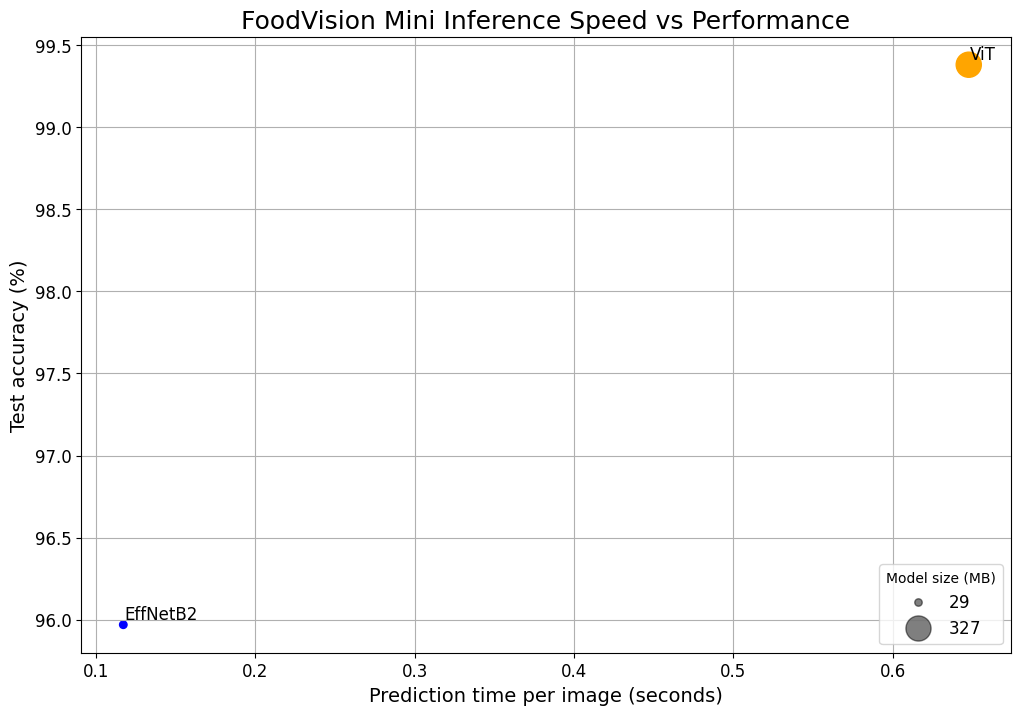

In [51]:
# 1. Create a plot from model comparison DataFrame
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df,
                     x="time_per_pred_cpu",
                     y="test_acc",
                     c=["blue", "orange"], # what colours to use?
                     s="model_size_MB") # size the dots by the model sizes

# 2. Add titles, labels and customize fontsize for aesthetics
ax.set_title("FoodVision Mini Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True)

# 3. Annotate with model names
for index, row in df.iterrows():
    ax.annotate(text=row["model"], # note: depending on your version of Matplotlib, you may need to use "s=..." or "text=...", see: https://github.com/faustomorales/keras-ocr/issues/183#issuecomment-977733270
                xy=(row["time_per_pred_cpu"]+0.0006, row["test_acc"]+0.03),
                size=12)

# 4. Create a legend based on model sizes
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles,
                              labels,
                              loc="lower right",
                              title="Model size (MB)",
                              fontsize=12)

# Save the figure
plt.savefig("09-foodvision-mini-inference-speed-vs-performance.jpg")

# Show the figure
plt.show()

## 7. Using Gradio for Deployment

In [52]:
# Import/install Gradio
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

print(f"Gradio version: {gr.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.2/20.2 MB 45.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.2/298.2 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 7.9 MB/s eta 0:

### 7.1 Creating the function for predictions

In [53]:
effnetb2 = effnetb2.to("cpu")

print(next(iter(effnetb2.parameters())).device)

cpu


In [56]:
def pred(img):

  start_time = timer()

  transformed_img = effnetb2_transforms(img).unsqueeze(0)

  effnetb2.eval()
  with torch.inference_mode():
    pred_probs = torch.softmax(effnetb2(transformed_img), dim=1)

  model_pred_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  end_time = timer()

  inference_time = round(end_time - start_time, 4)

  return model_pred_probs, inference_time

In [57]:
import random
from PIL import Image

# Get a list of all test image filepaths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]

# Open the target image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_dict, pred_time = pred(img=image)
print(f"Prediction label and probability dictionary: \n{pred_dict}")
print(f"Prediction time: {pred_time} seconds")

[INFO] Predicting on image at path: data/pizza_steak_sushi_20_percent/test/pizza/2111981.jpg

Prediction label and probability dictionary: 
{'pizza': 0.9526782035827637, 'steak': 0.024555696174502373, 'sushi': 0.02276603691279888}
Prediction time: 0.168 seconds


### 7.2 Creating list of examples for our app

In [64]:
example_imgs = [[str(path) for path in random.sample(test_data_paths, k=3)]]

In [65]:
example_imgs

[['data/pizza_steak_sushi_20_percent/test/steak/1902895.jpg',
  'data/pizza_steak_sushi_20_percent/test/sushi/2903125.jpg',
  'data/pizza_steak_sushi_20_percent/test/pizza/771336.jpg']]

In [68]:
import gradio as gr

# Create title, description and article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

demo = gr.Interface(fn=pred,
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), gr.Number(label="Prediction Time")],
                    examples=example_imgs,
                    title=title,
                    description=description,
                    article=article)

demo.launch(debug=False,
            share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://2087b6445fdd9a4771.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
